# Introducción

- Alumna: Abril Nazarena Rodriguez

- Legajo: R-4582/9

- Asignatura: Procesamiento de Imágenes y Visión por Computadora

El presente notebook consta de la resolución del ejercicio 8 de la práctica de la unidad 1 de la materia.

# Librerías

In [1]:
%%capture
# Instalación de paquetes
!pip install torchvision mediapy ultralytics pytube moviepy transformers timm
!pip install ultralytics==8.0.196

# Importación de bibliotecas
import cv2
import numpy as np
import torch
from pytube import YouTube
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import mediapy as media
from ultralytics import YOLO
from transformers import pipeline
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from torchvision import transforms
from ultralytics import YOLO
import ultralytics

# Limpieza de salida en el notebook
from IPython import display
display.clear_output()

El objetivo de este ejercicio es, a partir de un video de Youtube que muestra una bicicleta moviéndose entre una gran cantidad de personas, detectar la clase minoritaria. Para lograr esto, utilizaré los algoritmos de detección vistos en clase.

Al finalizar el ejercicio, compararé los niveles de confianza de las detecciones realizadas y sacaré conclusiones basadas en los resultados obtenidos.

En primer lugar, definí la función '**descargar_video**' que se encarga de la descarga y el recorte del video obtenido de Youtube.

In [2]:
def descargar_video(url, nombre_archivo, tiempo_inicio, tiempo_final):
    '''Recibe una url de youtube y descarga el video recortado según el tiempo de inicio y final ingresados'''
    yt = YouTube(url)
    video = yt.streams.filter(file_extension='mp4', res="720p").first()
    video.download(filename=nombre_archivo)
    nombre_archivo_recortado = nombre_archivo.split(".")[0] + "_recortado.mp4"
    ffmpeg_extract_subclip(nombre_archivo, tiempo_inicio, tiempo_final, targetname=nombre_archivo_recortado)
    nombre_archivo_600 = nombre_archivo.split(".")[0] + "_600.mp4"
    !ffmpeg -y -i {nombre_archivo_recortado} -vf "scale=600:-1" -an -t 30 {nombre_archivo_600}

In [3]:
url = "https://www.youtube.com/watch?v=YzcawvDGe4Y"
nombre_archivo = "bici.mp4"
tiempo_inicio = 76  # 1:16
tiempo_final = 82   # 1:22

descargar_video(url, nombre_archivo, tiempo_inicio, tiempo_final)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-lib

Una vez definida y llamada la función, muestro el video resultante.

In [4]:
video_bici = media.read_video('bici_600.mp4')
media.show_video(video_bici)

Antes de comenzar a aplicar los modelos, definí la función '**procesar_video**' (que también utilicé para los ejercicios 5 y 7 entregados la semana pasada), la cual toma como entrada un video, una función de procesamiento, un nombre para el video de salida y un tiempo máximo para procesar el video. Esta función genera un nuevo video, cuyo nombre se especifica mediante el parámetro '*filename_out*', luego de procesar el video de entrada '*filename_in*' utilizando la función de procesamiento proporcionada '*process_func*'. Por defecto, el parámetro que indica la duración máxima del video resultante '*max_time*' tiene un valor predeterminado de 10 segundos, pero puede modificarse según se desee.

In [5]:
def procesar_video(filename_in, filename_out, process_func, max_time=10, **kwargs):
    '''Recibe un video y, luego de procesarlo con la función pasada por parámetro, devuelve el video resultante'''

    with media.VideoReader(filename_in) as r:    # abro el video de entrada para lectura

        with media.VideoWriter(filename_out, shape=r.shape, fps=r.fps, bps=r.bps) as w:  # Creo un archivo de video de salida
            count = 0  # contador de fotogramas
            prev_image = None  # imagen previa

            # itero sobre cada imagen (fotograma) del video
            for image in r:

                new_image = media.to_uint8(image)  # convierto la imagen a formato flotante

                if prev_image is None: prev_image = new_image.copy()   # compruebo si es la primera imagen

                processed_image = process_func(new_image, prev_image, **kwargs) # utilizando la función dada, proceso la imagen

                w.add_image(processed_image)   # añado la imagen procesada al video de salida

                prev_image = new_image.copy() # actualizo la imagen previa

                count += 1  # incremento el contador de fotogramas

                if count >= max_time * r.fps:   # cuando se alcance el tiempo máximo, detengo el proceso
                    break

# YOLO

El primer método que apliqué es YOLO.

Comencé cargando el modelo pre-entrenado de YOLOv8, almacenándolo en la variable '*model*'.

Posteriormente, definí la función '**detect_objects**', la cual tiene la capacidad de detectar los objetos presentes en el frame recibido como entrada. Si entre los objetos detectados se encuentra la clase de interés especificada, se dibuja un bounding box alrededor del objeto identificado y se muestra la confianza de la detección. Finalmente, la función devuelve el frame modificado.

In [6]:
model = YOLO('yolov8n')  # cargo el modelo pre-entrenado

100%|██████████| 6.23M/6.23M [00:00<00:00, 74.3MB/s]


In [7]:
def detect_objects(new_image, prev_image, **kwargs):
    '''Recibe un frame y dibuja un bounding box y la confianza si la clase de interés se detecta en él,
    según el modelo YOLO'''
    results = model(new_image)

    classes = kwargs.get('classes', ['bike', 'bicycle'])  # clases de interés

    for box in results[0].boxes:
        x1, y1, x2, y2, confidence, cls = box.data[0]  # datos del tensor
        class_name = model.names[int(cls)]  # nombre de la clase
        color = kwargs.get('color', (0, 255, 0))
        thickness = kwargs.get('thickness', 2)
        if class_name in classes:  # si coincide con la clase de interés --> dibujo el bounding box y la confianza
            cv2.rectangle(new_image, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
            confidence_text = f"{class_name}: {confidence:.2f}"
            cv2.putText(new_image, confidence_text, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return new_image

Finalmente, definí el nombre del archivo de salida y la clase de interés '*bicycle*' dentro de la variable parameters, llamé a la funcón y visualicé los resultados.

In [8]:
filename_out = 'bici_yolo.mp4'  # nombre archivo de salida
parameters = dict(classes=['bicycle'])    # clase de interés

procesar_video('bici_600.mp4', filename_out, detect_objects, 20, **parameters)  # llamo a la función

media.show_video(media.read_video(filename_out), fps=30) # muestro el video resultante

Durante la ejecución del algoritmo, observé que YOLO es capaz de identificar una gran cantidad de personas en cada frame del video. Además, detecta la presencia de bolsos y mochilas (aunque quité las leyendas al ejecutarse).

Sin embargo, en lo que respecta a la clase de interés, la bicicleta, el modelo muestra un buen rendimiento, logrando precisión al identificarla.

Como se dificulta la visualización de la confianza detectada debido al constante movimiento de la bicicleta, realicé tres pausas durante la reproducción del video: al inicio, cuando la bicicleta comienza a aparecer en el cuadro; en la mitad del video, cuando se aprecia en su totalidad; y cuando la bicicleta está saliendo del cuadro.

En el primer momento de pausa (Frame 1), se muestra una confianza de detección de 0.89. Esta confianza aumenta ligeramente en el segundo momento de pausa (Frame 2), alcanzando un valor de 0.93. Sin embargo, al finalizar el video y con la bicicleta saliendo del cuadro, la confianza detectada disminuye a 0.67 (Frame 3).

**Frame 1**:

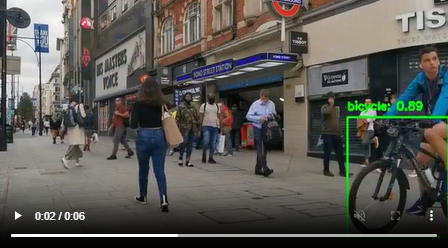

**Frame 2**:

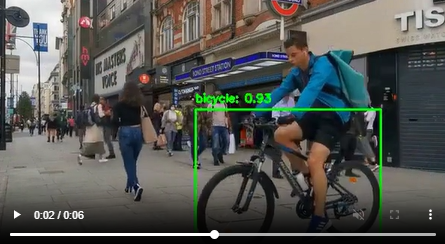

**Frame 3**:

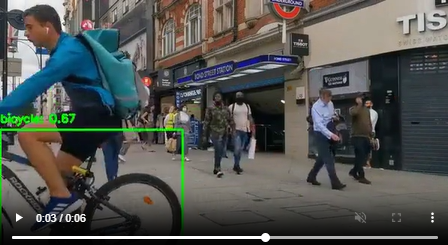

Para este video en particular, considero que los resultados obtenidos por YOLO son buenos. No sólo identifica precisamente la ubicación de la bicicleta, sino que también es capaz de identificarla incluso cuando no se visualiza en su totalidad.

# MobileNetSSD

El siguiente modelo a probar sobre el video de la bicicleta es MobileNetSSD.

Si bien en clase hemos trabajado este modelo únicamente sobre imágenes, he adaptado el código para que sea capaz de trabajar con un video mediante la función '**mobile_net_ssd**'. Esta función recibe un frame, lo prepara para la red y obtiene las detecciones. En el caso de que encuentre la clase de interés (en este caso la bicicleta) dibuja su bounding box y el porcentaje de confianza. Finalmente, devuelve dicho frame modificado.

In [9]:
%%capture
!wget -O 'MobileNetSSD_deploy.prototxt' https://raw.githubusercontent.com/TheNsBhasin/DNN_Object_Detection/master/MobileNetSSD_deploy.prototxt.txt
!wget -O 'MobileNetSSD_deploy.caffemodel' https://github.com/TheNsBhasin/DNN_Object_Detection/blob/master/MobileNetSSD_deploy.caffemodel?raw=true

In [10]:
modelo = 'MobileNetSSD_deploy.caffemodel'  # modelo preentrenado
configuracion = 'MobileNetSSD_deploy.prototxt'
clases = ["background", "aeroplane", "bicycle", "bird", "boat",
          "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
          "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
          "sofa", "train", "tvmonitor"]
net = cv2.dnn.readNetFromCaffe(configuracion, modelo) # cargo red neuronal

In [11]:
def mobile_net_ssd(frame, prev_frame):
  '''Recibe un frame y, si el modelo de MobileNetSSD detecta la clase bicicleta
  lo devuelve con su bounding box y porcentaje de confianza'''
  (h, w) = frame.shape[:2] # obtengo el alto y el ancho del frame
  blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 0.007843, (300, 300), 127.5)
  net.setInput(blob)
  detecciones = net.forward() # paso el blob a través de la red y obtengo las detecciones

  for i in np.arange(0, detecciones.shape[2]):
      confianza = detecciones[0, 0, i, 2]

      if confianza > 0.2:  # filtro detecciones débiles
          idx = int(detecciones[0, 0, i, 1])
          if clases[idx] == "bicycle":
            box = detecciones[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            etiqueta = "{}: {:.2f}%".format(clases[idx], confianza * 100)
            cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(frame, etiqueta, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

  return frame   # devuelvo el frame con sus modificaciones

Una vez cargado el modelo y definida la función, llamo a '**procesar_video**' y muestro los resultados.

In [12]:
filename_out = 'bici_MobileNetSSD.mp4'  # nombre archivo de salida

procesar_video('bici_600.mp4', filename_out, mobile_net_ssd)  # llamo a la función

media.show_video(media.read_video('bici_MobileNetSSD.mp4'), fps=30) # muestro el video resultante

A continuación, muestro para el caso de MobileNetSSD los resultados de los mismos frames que capturé para el modelo anterior.

En el primer cuadro, donde la bicicleta recién aparece, los resultados de MobileNetSSD muestran una confianza del 59.30%, en comparación con el 89% obtenido por YOLO. Sin embargo, a medida que avanza el video, se evidencia una notable mejora en los siguientes cuadros. Cuando la bicicleta se visualiza en su totalidad, la confianza alcanzada por MobileNetSSD es de un 99.99%, mientras que YOLO registra un 93%. Por último, cuando la bicicleta sale del cuadro, la confianza sigue siendo alta, alcanzando un 97% con MobileNetSSD, en contraste con el 67% obtenido por YOLO.

**Frame 1**:

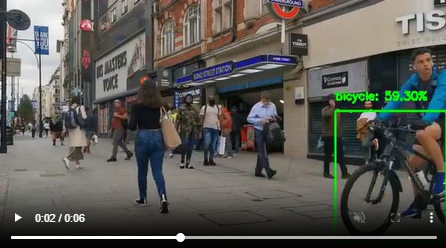

**Frame 2**:

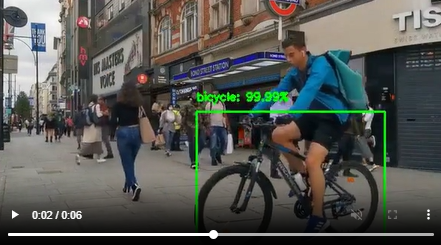

**Frame 3**:

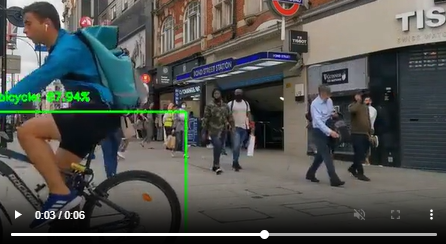

En conclusión, se observa una gran mejora en el desempeño de MobileNetSSD en comparación con YOLO cuando el objeto de interés se encuentra completamente visible en el frame.

# DETR (Transformers)

El último modelo que probaré es DERT, de transformers.

In [13]:
%%capture
!wget "https://github.com/openmaptiles/fonts/raw/master/roboto/Roboto-Regular.ttf" -O "Roboto-Regular.ttf"

In [14]:
# Descargar y cargar la fuente correctamente
font = ImageFont.truetype("Roboto-Regular.ttf", 40)

# Inicializar el pipeline de detección de objetos específicamente indicando el modelo
object_detector = pipeline("object-detection", model="facebook/detr-resnet-50")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

Una vez cargado el modelo, definí dos funciones: '**draw_bounding_dox**', que dibuja los bounding boxes y la etiqueta de confianza; y '**detr**' que utiliza el modelo de Transformers para detectar los objetos en el frame que recibe por parámetro, devolviendo el mismo con el objeto de interés detectado.

In [15]:
def draw_bounding_box(frame, score, label, xmin, ymin, xmax, ymax, index, num_boxes):
    '''Recibe un frame y dibuja un bounding box en él según los puntos recibidos por parámetro'''
    im_with_rectangle = ImageDraw.Draw(frame)
    im_with_rectangle.rounded_rectangle([xmin, ymin, xmax, ymax], outline="red", width=5, radius=10) # dibuja bounding box
    im_with_rectangle.text((xmin + 10, ymin - 40), f"{label} ({score:.2f})", fill="white", font=font) # dibuja etiqueta
    return frame

In [16]:
def detr(frame, prev_frame):
    '''Recibe un frame y, luego de detectar los objetos en él según el modelo DETR, devuelve un
     frame con sus bounding boxes dibujados'''

    pil_image = Image.fromarray(frame)
    bounding_boxes = object_detector(pil_image)
    num_boxes = len(bounding_boxes)

    for index, bounding_box in enumerate(bounding_boxes):
        box = bounding_box['box']
        if bounding_box['label'] == 'bicycle':
          frame = draw_bounding_box(pil_image, bounding_box['score'], bounding_box['label'],
                               int(box['xmin']), int(box['ymin']), int(box['xmax']),
                               int(box['ymax']), index, num_boxes)
    new_frame = np.array(frame, dtype=np.uint8)

    return new_frame

In [17]:
filename_out = 'bici_DETR.mp4'  # nombre archivo de salida

procesar_video('bici_600.mp4', filename_out, detr)  # llamo a la función

media.show_video(media.read_video('bici_DETR.mp4' ), fps=30) # muestro el video resultante

A continuación, mostraré tres frames resultantes del modelo de Transformers.

Esta vez, no fue posible capturar exactamente el mismo cuadro en el que la bicicleta entra en la escena, ya que la confianza no es claramente visible debido al tamaño grande de las etiquetas. Sin embargo, se observa que la confianza cuando la bicicleta entra en el cuadro (Frame 1) es del 100%, lo que indica que el modelo está completamente seguro de que el objeto es una bicicleta.

Esta certeza se mantiene en el segundo cuadro que capturé, donde se visualiza la bicicleta en su totalidad, alcanzando también el 100% de confianza (Frame 2).

Por último, cuando la bicicleta está por salir del cuadro, la confianza disminuye ligeramente, alcanzando el 99% (Frame 3).

**Frame 1**:

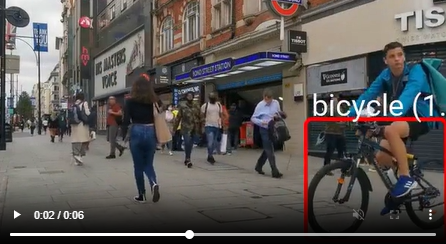

**Frame 2**:

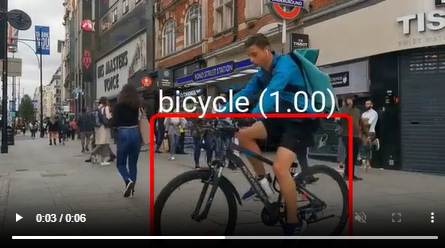

**Frame 3**:

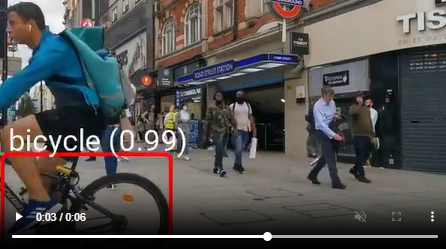

El rendimiento del modelo DETR de Transformers es excelente, alcanzando aproximadamente el 100% de confianza en todos los cuadros donde la bicicleta está presente.

Vale la pena destacar que, a diferencia de los otros modelos que probé, donde el porcentaje de confianza disminuye cuando la bicicleta no está completamente visible, con DETR el modelo muestra una gran seguridad en su detección. Incluso cuando solo se visualiza una parte de la bicicleta, como una rueda, el modelo es capaz de detectarla con un alto grado de confianza.

A continuación, muestro una comparativa de los tres modelos cuando sólo se visualiza una rueda.

**DETR**:

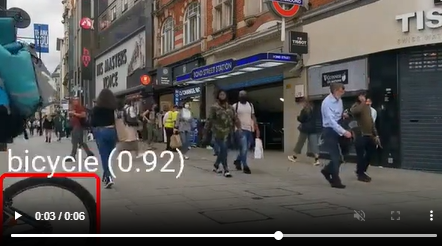

**MobileNetSSD**:

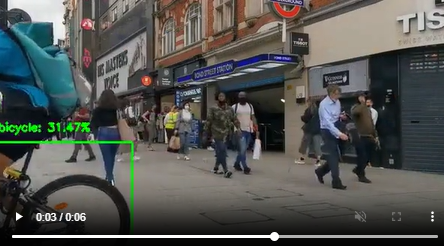

**YOLO**:

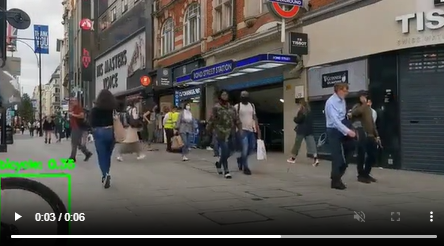

Mientras que el modelo de Transformers logra una confianza del 92%, tanto MobileNetSSD como YOLO apenas alcanzan un rango de confianza del 31% al 35%.

Además, destaco que a diferencia de los otros, la detección de DETR es mucho más fluida que la de los otros modelos.